In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *

import os, gc, random
import time
print(os.listdir("../input"))
import sys
print(sys.modules['fastai'])
from fastai.utils.show_install import *
show_install()

['test', 'training', 'SampleSubmission.csv', 'IdLookupTable.csv']
<module 'fastai' from '/opt/conda/lib/python3.6/site-packages/fastai/__init__.py'>


```text
=== Software === 
python        : 3.6.6
fastai        : 1.0.46
fastprogress  : 0.1.20
torch         : 1.0.0
nvidia driver : 396.44
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.9.0-5-amd64-x86_64-with-debian-9.4
distro        : #1 SMP Debian 4.9.65-3+deb9u2 (2018-01-04)
conda env     : Unknown
python        : /opt/conda/bin/python
sys.path      : 
/kaggle/lib/kagglegym
/kaggle/lib
/opt/conda/lib/python36.zip
/opt/conda/lib/python3.6
/opt/conda/lib/python3.6/lib-dynload
/root/.local/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages/nolearn-0.6.1.dev0-py3.6.egg
/opt/conda/lib/python3.6/site-packages/tabul

In [2]:
# make training deterministic/reproducible
def seed_everything(seed=2018):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

def to_img(*args):
    return np.array(args, dtype=np.uint8)

def conv2(ni, no, kernel_size=3, stride=2, padding=0):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
#         nn.ReLU(inplace=True),
        nn.LeakyReLU(inplace=True),
        nn.BatchNorm2d(no)
    )

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class ResBlock(nn.Module):
    def __init__(self, nf):
        super(ResBlock, self).__init__()
        self.conv1 = conv2(nf, nf, kernel_size=3, stride=1, padding=1)
        self.conv2 = conv2(nf, nf, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = x + self.conv2(self.conv1(x))
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class ExImagePoints(ImagePoints):
    def reconstruct(self, t, x): return ExImagePoints(FlowField(x.size, t), scale=False)

class PointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList):
        print('PointsProcessor')
        print(ds)
        self.c = len(ds.items[0].reshape(-1))
    def process(self, ds:ItemList):
        ds.c = self.c

class ExPointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = PointsProcessor

    def __post_init__(self): self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        o = torch.tensor(o.astype(np.float32), dtype=torch.float32)
        return ExImagePoints(FlowField(self.x.get(i).size, o), scale=True, y_first=False)

    def analyze_pred(self, pred, thresh:float=0.5): return pred.view(-1,2)


class ExPointsItemList(ImageList):
    _label_cls,_square_show_res = ExPointsLabelList,False

    def open(self, fn):
        img = (to_img(*fn.split(' '))/255).reshape(1,96,96)
        return Image(torch.tensor(img, dtype=torch.float32))

In [5]:
train_df = pd.read_csv('../input/training/training.csv')
test_df = pd.read_csv('../input/test/test.csv')

In [6]:
# check to missing values
train_df.isna().any().value_counts()

True     28
False     3
dtype: int64

In [7]:
print(train_df.shape)
# drop N/As
train_df.dropna(inplace=True)
train_df.shape

(7049, 31)


(2140, 31)

In [8]:
labels = train_df.drop('Image',axis = 1).values.astype(np.float32)
labels = labels.reshape(-1, 15, 2)
# ## convert from (x,y) to (y,x)
# labels = labels[:, :, [1,0]]
labels = torch.tensor(labels, dtype=torch.float32)

In [9]:
valid_pct = 0.2
rand_idx = np.random.permutation(len(train_df))
cut = int(valid_pct * len(train_df))
train_idxs, valid_idxs = rand_idx[cut:],rand_idx[:cut]
train_idxs.shape,valid_idxs.shape

((1712,), (428,))

In [10]:
data = ExPointsItemList(items=train_df.Image, path='.')
data = data.split_by_idxs(train_idx=train_idxs,valid_idx=valid_idxs)
data = data.label_from_lists(labels[train_idxs],labels[valid_idxs])
# data = data.databunch(bs=16)
# data

PointsProcessor
ExPointsLabelList (1712 items)
ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96)
Path: .


In [11]:
empty_labels = np.zeros((len(test_df.Image), 15, 2))
data = data.add_test(items=test_df.Image, label=empty_labels)

In [12]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_rotate=0.0, 
                      max_zoom=1.0, 
                      max_lighting=0.2, 
                      max_warp=0.0, 
                      p_affine=0.8, 
                      p_lighting=0.8)
data = data.transform(tfms=tfms)

In [13]:
data = data.databunch(bs=16)
data

ImageDataBunch;

Train: LabelList (1712 items)
x: ExPointsItemList
Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96)
y: ExPointsLabelList
ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96)
Path: .;

Valid: LabelList (428 items)
x: ExPointsItemList
Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96)
y: ExPointsLabelList
ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96)
Path: .;

Test: LabelList (1783 items)
x: ExPointsItemList
Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96),Image (1, 96, 96)
y: ExPointsLabelList
ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96),ExImagePoints (96, 96)
Path: .

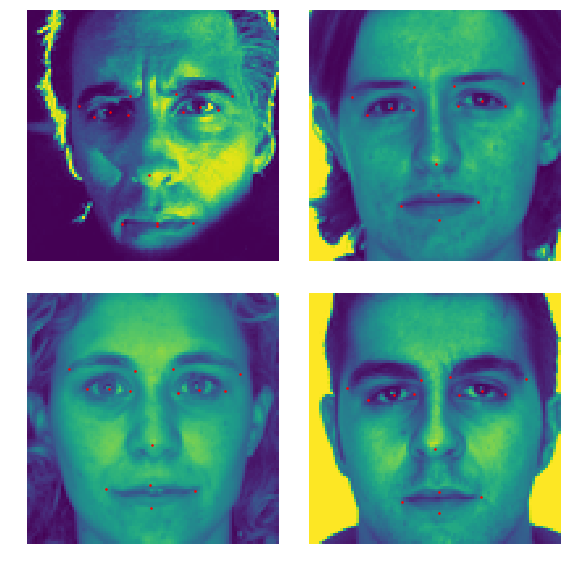

In [14]:
data.show_batch(rows=2)

In [15]:
model = nn.Sequential(
    conv2(1, 4, kernel_size=5, stride=1, padding=2),
    ResBlock(4),
    nn.MaxPool2d(2,2),
    conv2(4, 6, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(2,2),
    conv2(6, 8, kernel_size=4, stride=1, padding=2),
    nn.MaxPool2d(2,2),
    Flatten(),
    nn.Dropout(0.5),
    nn.Linear(12 * 12 * 8, 250),
    nn.Dropout(0.5),
    nn.Linear(250, 30),
)

In [16]:
# (xs,ys) = data.one_batch()
# model(xs).shape

In [17]:
def rmse(preds, targets):
    return torch.sqrt(nn.functional.mse_loss(preds, targets.view(targets.size(0), -1)))

def mse(preds, targets):
    return nn.functional.mse_loss(preds, targets.view(targets.size(0), -1)) 

learn = Learner(data, model, loss_func=mse, metrics=rmse)

In [18]:
learn.lr_find(end_lr=100)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


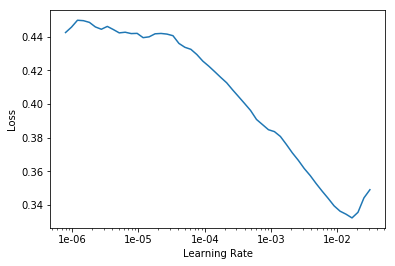

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(20, max_lr=1e-2/2)

epoch,train_loss,valid_loss,rmse,time
1,0.139181,0.015447,0.124009,00:08
2,0.055406,0.007795,0.087935,00:08
3,0.020789,0.004933,0.069681,00:09
4,0.009755,0.006305,0.078910,00:09
5,0.008332,0.004981,0.070031,00:10
6,0.005552,0.004564,0.066973,00:08
7,0.004072,0.003317,0.056930,00:08
8,0.003257,0.003121,0.055063,00:08
9,0.003099,0.002914,0.053291,00:08
10,0.003039,0.003338,0.057038,00:08


## Test set

In [21]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [22]:
preds.min(),preds.max()

(tensor(-0.7807), tensor(0.9164))

In [23]:
preds = preds * 48 + 48

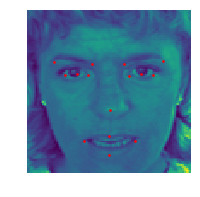

In [24]:
def show_im(img, pnts):
    img = (to_img(*img.split(' '))/255).reshape(1,96,96)
    img = Image(torch.tensor(img, dtype=torch.float32))
    pnts = pnts.reshape(15, 2)
    pnts = ImagePoints(FlowField(img.size, pnts), y_first=True)
    img.show(y=pnts)

show_im(test_df.Image[1], preds[1])
# show_im(train_df.Image[0], labels[0][:,[1,0]].reshape(-1))

In [25]:
# (y,x) -> (x,y)
preds = preds.reshape(-1, 15, 2)[:, :, [1,0]]
preds = preds.reshape(-1, 30)
preds = preds.detach().numpy()

### Submit Result

In [26]:
look_id = pd.read_csv('../input/IdLookupTable.csv')
look_id.drop('Location',axis=1,inplace=True)

In [27]:
columns = train_df.drop('Image', axis=1).columns

In [28]:
ind = np.array(columns)
value = np.array(range(0,30))
maps = pd.Series(value,ind)

In [29]:
look_id['location_id'] = look_id.FeatureName.map(maps)

In [30]:
df = look_id.copy()
location = pd.DataFrame({'Location':[]})
for i in range(1,1784):
    ind = df[df.ImageId==i].location_id
    location = location.append(pd.DataFrame(preds[i-1][list(ind)],columns=['Location']), ignore_index=True)

In [31]:
look_id['Location']=location

In [32]:
look_id[['RowId','Location']].to_csv('submission.csv',index=False)

In [33]:
!ls

__notebook__.ipynb  __output__.json  models  submission.csv
